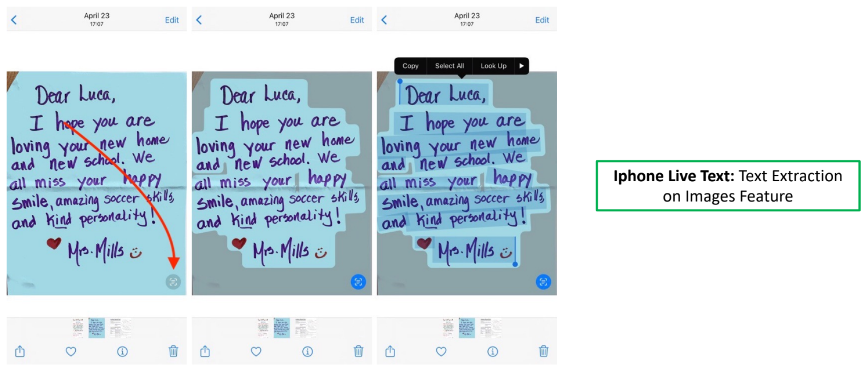

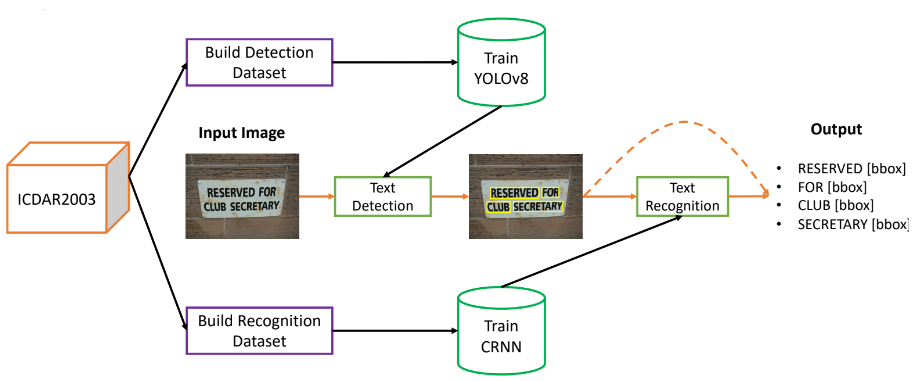

# **Text Detection**

In [ ]:
import os
import shutil
import yaml
import xml.etree.ElementTree as ET

from sklearn.model_selection import train_test_split

## Data

In [ ]:
!gdown --id 1x9e2FNDlKc_lBkJvHvWSKKfCSSqNsQfM

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1x9e2FNDlKc_lBkJvHvWSKKfCSSqNsQfM
From (redirected): https://drive.google.com/uc?id=1x9e2FNDlKc_lBkJvHvWSKKfCSSqNsQfM&confirm=t&uuid=dc6c7e56-d43d-49ba-85d2-e8b3baa6100b
To: /content/icdar2003.zip
100% 45.7M/45.7M [00:00<00:00, 126MB/s]


In [ ]:
!unzip /content/icdar2003.zip

Archive:  /content/icdar2003.zip
   creating: SceneTrialTrain/apanar_06.08.2002/
  inflating: SceneTrialTrain/apanar_06.08.2002/IMG_1247.JPG  
  inflating: SceneTrialTrain/apanar_06.08.2002/IMG_1252.JPG  
  inflating: SceneTrialTrain/apanar_06.08.2002/IMG_1253.JPG  
  inflating: SceneTrialTrain/apanar_06.08.2002/IMG_1255.JPG  
  inflating: SceneTrialTrain/apanar_06.08.2002/IMG_1259.JPG  
  inflating: SceneTrialTrain/apanar_06.08.2002/IMG_1261.JPG  
  inflating: SceneTrialTrain/apanar_06.08.2002/IMG_1263.JPG  
  inflating: SceneTrialTrain/apanar_06.08.2002/IMG_1265.JPG  
  inflating: SceneTrialTrain/apanar_06.08.2002/IMG_1269.JPG  
  inflating: SceneTrialTrain/apanar_06.08.2002/IMG_1281.JPG  
  inflating: SceneTrialTrain/apanar_06.08.2002/IMG_1282.JPG  
  inflating: SceneTrialTrain/apanar_06.08.2002/IMG_1283.JPG  
  inflating: SceneTrialTrain/apanar_06.08.2002/IMG_1284.JPG  
  inflating: SceneTrialTrain/apanar_06.08.2002/IMG_1285.JPG  
  inflating: SceneTrialTrain/apanar_06.08.2002/IMG_

In [ ]:
def extract_data_from_xml(root_dir):
    '''
    return:
        tuple: Contains 4 lists in order: image paths, image sizes, image labels, and bboxes.
    '''
    xml_path = os.path.join(root_dir, 'words.xml')
    tree = ET.parse(xml_path)
    root = tree.getroot()

    image_paths = []
    image_sizes = []
    image_labels = []
    image_bboxes = []

    for image in root:
        bboxes_of_image = []
        labels_of_image = []

        # Iterate through each bounding box tag
        for bboxes in image.findall('taggedRectangles'):
            for bbox in bboxes:
                if not bbox[0].text.isalnum():  # Real-time, C.J.
                    continue
                if 'é' in bbox[0].text.lower() or 'ñ' in bbox[0].text.lower():  # Café, ESPAÑOL
                    continue

                bboxes_of_image.append(
                    [
                        float(bbox.attrib['x']),
                        float(bbox.attrib['y']),
                        float(bbox.attrib['width']),
                        float(bbox.attrib['height']),
                    ]
                )
                labels_of_image.append(bbox[0].text.lower())

        image_paths.append(os.path.join(root_dir, image[0].text))
        image_sizes.append((int(image[1].attrib['x']), int(image[1].attrib['y'])))
        image_labels.append(labels_of_image)
        image_bboxes.append(bboxes_of_image)

    return image_paths, image_sizes, image_labels, image_bboxes

In [ ]:
dataset_dir = '/content/SceneTrialTrain'
image_paths, image_sizes, image_labels, bounding_boxes = extract_data_from_xml(dataset_dir)

In [ ]:
image_paths[0], image_sizes[0]

('/content/SceneTrialTrain/apanar_06.08.2002/IMG_1261.JPG', (1600, 1200))

In [ ]:
for label, bbox in zip(image_labels[0], bounding_boxes[0]):
    print(f'{label} \t {bbox}')

self 	 [174.0, 392.0, 274.0, 195.0]
adhesive 	 [512.0, 391.0, 679.0, 183.0]
address 	 [184.0, 612.0, 622.0, 174.0]
labels 	 [863.0, 599.0, 446.0, 187.0]
36 	 [72.0, 6.0, 95.0, 87.0]
89m 	 [247.0, 2.0, 197.0, 88.0]
cls 	 [792.0, 0.0, 115.0, 81.0]
250 	 [200.0, 848.0, 228.0, 139.0]
on 	 [473.0, 878.0, 165.0, 109.0]
a 	 [684.0, 878.0, 71.0, 106.0]
roll 	 [806.0, 844.0, 218.0, 141.0]


In [ ]:
# Convert to YOLOv8 format
def convert_to_yolov8_format(image_paths, image_sizes, bounding_boxes):
    """
    Normalize bounding boxes

    Parameters:
        image_paths (list): List containing image paths.
        image_sizes (list): List containing image resolutions.
        bounding_boxes (list): List containing lists of bounding boxes.

    Returns:
        yolov8_data (list): A list consisting of (image_path, image_size, bboxes)
    """
    yolov8_data = []

    for image_path, image_size, bboxes in zip(image_paths, image_sizes, bounding_boxes):
        image_width, image_height = image_size

        # Declare an empty list to store labels (new format)
        yolov8_labels = []

        # Iterate through each bbox
        for bbox in bboxes:
            x, y, w, h = bbox

            # Current bbox format: (x_min, y_min, width, height)
            # YOLO bbox format: (x_center, y_center, width, height)
            center_x = (x + w / 2) / image_width
            center_y = (y + h / 2) / image_height
            normalized_width = w / image_width
            normalized_height = h / image_height

            class_id = 0

            # Format: "class_id x_center y_center width height"
            yolov8_label = f"{class_id} {center_x} {center_y} {normalized_width} {normalized_height}"
            yolov8_labels.append(yolov8_label)

        yolov8_data.append((image_path, yolov8_labels))

    return yolov8_data

In [ ]:
# Define class
class_labels = ['text']

# Call the function
yolov8_data = convert_to_yolov8_format(
    image_paths,
    image_sizes,
    bounding_boxes
)

In [ ]:
yolov8_data[0]

('/content/SceneTrialTrain/apanar_06.08.2002/IMG_1261.JPG',
 ['0 0.194375 0.40791666666666665 0.17125 0.1625',
  '0 0.5321875 0.40208333333333335 0.424375 0.1525',
  '0 0.309375 0.5825 0.38875 0.145',
  '0 0.67875 0.5770833333333333 0.27875 0.15583333333333332',
  '0 0.0746875 0.04125 0.059375 0.0725',
  '0 0.2159375 0.03833333333333333 0.123125 0.07333333333333333',
  '0 0.5309375 0.03375 0.071875 0.0675',
  '0 0.19625 0.7645833333333333 0.1425 0.11583333333333333',
  '0 0.3471875 0.7770833333333333 0.103125 0.09083333333333334',
  '0 0.4496875 0.7758333333333334 0.044375 0.08833333333333333',
  '0 0.571875 0.7620833333333333 0.13625 0.1175'])

In [ ]:
# Train, Val
train_data, test_data = train_test_split(
    yolov8_data,
    test_size=0.2,
    random_state=0,
    shuffle=True
)
test_data, val_data = train_test_split(
    test_data,
    test_size=0.125,
    random_state=0,
    shuffle=True
)

In [ ]:
len(train_data), len(val_data), len(test_data)

(200, 7, 43)

In [ ]:
def save_data(data, src_img_dir, save_dir):
    """
    Parameters:
        data (list): List containing image label information.
        src_img_dir (str): Path to the original dataset directory. '/content/SceneTrialTrain'
        save_dir (str): Path to the new dataset directory. 'datasets/yolo_data/.'
    """
    # Create new dataset directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    # Create 'images' and 'labels' subdirectories
    os.makedirs(os.path.join(save_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(save_dir, 'labels'), exist_ok=True)

    # Iterate through each image path and label
    for image_path, yolov8_labels in data:
        shutil.copy(
            os.path.join(src_img_dir, image_path),
            os.path.join(save_dir, 'images')
        )

        # Write label content to image_name.txt in 'labels' directory
        image_name = os.path.basename(image_path)  # '/content/SceneTrialTrain/lfsosa_12.08.2002/IMG_2506.JPG' --> 'IMG_2506.JPG'
        image_name = os.path.splitext(image_name)[0]  # IMG_2506

        with open(os.path.join(save_dir, 'labels', f"{image_name}.txt"),

In [ ]:
# Save data
save_yolo_data_dir = 'datasets/yolo_data'
os.makedirs(save_yolo_data_dir, exist_ok=True)
dataset_dir = '/content/SceneTrialTrain'

save_data(
    train_data,
    dataset_dir,
    os.path.join(save_yolo_data_dir, 'train')
)

save_data(
    test_data,
    dataset_dir,
    os.path.join(save_yolo_data_dir, 'val')
)

save_data(
    val_data,
    dataset_dir,
    os.path.join(save_yolo_data_dir, 'test')
)

In [ ]:
# Create yaml file
data_yaml = {
    'path': '/content/datasets/yolo_data',
    'train': 'train/images',
    'test': 'test/images',
    'val': 'val/images',
    'nc': 1,
    'names': class_labels
}

yolo_yaml_path = os.path.join(
    save_yolo_data_dir,
    'data.yml'
)
with open(yolo_yaml_path, 'w') as f:
    yaml.dump(data_yaml, f, default_flow_style=False)

## Training

In [ ]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.1.18 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.5/78.2 GB disk)


https://github.com/ultralytics/ultralytics

In [ ]:
from ultralytics import YOLO

# Load a model
model = YOLO('yolov8s.yaml').load('yolov8s.pt') # Load pretrained model: yolov8s

# Start training
results = model.train(
    data=yolo_yaml_path,
    epochs=200,
    imgsz=1024,
    project='models',
    name='yolov8/detect/train'
)

100%|██████████| 21.5M/21.5M [00:00<00:00, 197MB/s]

Transferred 355/355 items from pretrained weights


Ultralytics YOLOv8.1.18 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.yaml, data=datasets/yolo_data/data.yml, epochs=200, time=None, patience=100, batch=16, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=8, project=models, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True

100%|██████████| 755k/755k [00:00<00:00, 21.2MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 134MB/s]


AMP: checks passed ✅


train: Scanning /content/datasets/yolo_data/train/labels... 200 images, 7 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<00:00, 1429.37it/s]

train: New cache created: /content/datasets/yolo_data/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/datasets/yolo_data/val/labels... 43 images, 2 backgrounds, 0 corrupt: 100%|██████████| 43/43 [00:00<00:00, 980.76it/s]

val: New cache created: /content/datasets/yolo_data/val/labels.cache


Plotting labels to models/yolov8/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 2 dataloader workers
Logging results to models/yolov8/detect/train
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      9.58G       2.11      5.438      1.859         41       1024: 100%|██████████| 13/13 [00:15<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.43s/it]

                   all         43        200      0.415      0.555      0.455      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      9.77G      1.097      1.783      1.153         73       1024: 100%|██████████| 13/13 [00:08<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.72it/s]

                   all         43        200       0.73       0.67      0.683      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      9.47G      1.138      1.477      1.132         75       1024: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]

                   all         43        200      0.558        0.7      0.655      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      9.84G      1.141      1.255      1.154        101       1024: 100%|██████████| 13/13 [00:07<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.88it/s]

                   all         43        200      0.631       0.77      0.709      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      9.79G      1.174      1.158       1.18         55       1024: 100%|██████████| 13/13 [00:07<00:00,  1.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.86it/s]

                   all         43        200      0.395      0.415      0.321      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      9.73G      1.174      1.263      1.212         39       1024: 100%|██████████| 13/13 [00:08<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]

                   all         43        200      0.504      0.462      0.378      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200       9.8G       1.17      1.152      1.192         48       1024: 100%|██████████| 13/13 [00:08<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]

                   all         43        200     0.0418      0.085     0.0152    0.00449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      9.65G      1.313      1.188       1.28         42       1024: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.06it/s]

                   all         43        200      0.234      0.408      0.137     0.0685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      9.56G      1.183      1.131      1.221         37       1024: 100%|██████████| 13/13 [00:08<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.72it/s]

                   all         43        200     0.0435      0.095     0.0141    0.00469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      9.73G      1.232      1.168      1.239         89       1024: 100%|██████████| 13/13 [00:07<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         43        200      0.263      0.115     0.0958     0.0347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200       9.8G        1.2      1.106      1.213         56       1024: 100%|██████████| 13/13 [00:08<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]

                   all         43        200      0.406       0.38      0.294      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      9.88G      1.211      1.161      1.204         74       1024: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]

                   all         43        200      0.559      0.455      0.461       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200       9.8G      1.144      1.069      1.174         49       1024: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]

                   all         43        200      0.597      0.615      0.579      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      9.87G      1.154     0.9744      1.176         59       1024: 100%|██████████| 13/13 [00:08<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.91it/s]

                   all         43        200      0.719       0.69      0.716       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      9.86G      1.141      1.041        1.2         63       1024: 100%|██████████| 13/13 [00:08<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]

                   all         43        200        0.6       0.66      0.585      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      9.64G      1.167       1.01      1.184         54       1024: 100%|██████████| 13/13 [00:08<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]

                   all         43        200      0.772      0.715      0.757      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      9.77G      1.144      1.004      1.192         66       1024: 100%|██████████| 13/13 [00:12<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

                   all         43        200       0.71      0.715      0.719      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      10.3G      1.116      0.981      1.171         59       1024: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.95it/s]

                   all         43        200       0.73      0.795      0.789      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      9.79G      1.004     0.8788      1.114         39       1024: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]

                   all         43        200      0.745        0.8      0.775      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      9.86G      1.099     0.9355      1.137         73       1024: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]

                   all         43        200      0.857      0.809      0.857      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      9.83G      1.056     0.8932      1.141         92       1024: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.46it/s]

                   all         43        200      0.779      0.845      0.843      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      9.83G      1.053      0.869       1.11         41       1024: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]

                   all         43        200      0.838      0.799      0.863      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      10.3G       1.03     0.8786       1.13         51       1024: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]

                   all         43        200      0.742      0.835      0.782      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      9.86G      1.056     0.8458      1.108         91       1024: 100%|██████████| 13/13 [00:08<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.66it/s]

                   all         43        200      0.767       0.84      0.789      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      9.78G      1.048      0.867       1.13        117       1024: 100%|██████████| 13/13 [00:08<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]

                   all         43        200       0.78      0.889      0.829      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      9.75G      1.016     0.8546      1.108         72       1024: 100%|██████████| 13/13 [00:08<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]

                   all         43        200       0.83       0.86       0.88      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200        10G     0.9891     0.8776      1.111         48       1024: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.00it/s]

                   all         43        200      0.778       0.77      0.816      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200       9.6G     0.9766     0.8181      1.078         60       1024: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]

                   all         43        200      0.785       0.85      0.833      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      9.77G     0.9417     0.7572      1.073         69       1024: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]

                   all         43        200       0.84      0.817      0.853      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      9.72G     0.9776     0.8037      1.094         48       1024: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]

                   all         43        200      0.806       0.89      0.849      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      9.73G     0.9169      0.834      1.074         52       1024: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  2.00it/s]

                   all         43        200      0.781      0.802       0.79      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      9.57G     0.9557     0.7668      1.086         88       1024: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.12it/s]

                   all         43        200      0.821      0.855      0.846      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      9.72G     0.9804     0.7846      1.095         85       1024: 100%|██████████| 13/13 [00:08<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.91it/s]

                   all         43        200      0.823      0.825      0.853      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      9.73G     0.9376     0.7056      1.057         54       1024: 100%|██████████| 13/13 [00:08<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.06it/s]

                   all         43        200      0.813      0.825      0.836      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      9.82G       0.98     0.7927      1.092         29       1024: 100%|██████████| 13/13 [00:08<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]

                   all         43        200      0.751      0.895      0.841      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      9.81G     0.9846      0.777      1.097         40       1024: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.91it/s]

                   all         43        200      0.807      0.876      0.844      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      9.72G     0.9137     0.7423       1.05         43       1024: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.73it/s]

                   all         43        200      0.811       0.88      0.858      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      9.85G     0.9184     0.7593      1.065         63       1024: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.70it/s]

                   all         43        200      0.845      0.847      0.857      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      9.52G     0.9459     0.7596       1.06         37       1024: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]

                   all         43        200      0.795      0.833      0.883      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      9.81G     0.9342     0.7501      1.055         66       1024: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]

                   all         43        200      0.842      0.865      0.888      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      9.78G     0.9077       0.74      1.054         55       1024: 100%|██████████| 13/13 [00:08<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]

                   all         43        200      0.804      0.885      0.851      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      10.2G     0.8954     0.7311      1.055         35       1024: 100%|██████████| 13/13 [00:08<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]

                   all         43        200      0.786      0.885      0.845      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      9.84G     0.9136     0.7485      1.073         38       1024: 100%|██████████| 13/13 [00:08<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]

                   all         43        200      0.856      0.835      0.874      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      9.98G     0.9446     0.7406      1.057         51       1024: 100%|██████████| 13/13 [00:08<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  2.00it/s]

                   all         43        200      0.784      0.865       0.84      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      9.52G     0.8996     0.6902      1.037         72       1024: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.39it/s]

                   all         43        200      0.814       0.83      0.847      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      9.78G     0.8638     0.6921      1.025         55       1024: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.73it/s]

                   all         43        200      0.841      0.896      0.881      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      10.2G     0.9047     0.7152      1.056         78       1024: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]

                   all         43        200      0.807       0.88      0.876      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      9.58G     0.8754      0.678      1.041         32       1024: 100%|██████████| 13/13 [00:08<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.21it/s]

                   all         43        200      0.824      0.868      0.867      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      9.43G     0.8541     0.6706      1.029         59       1024: 100%|██████████| 13/13 [00:08<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.84it/s]

                   all         43        200      0.767      0.903      0.853       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200       9.8G      0.874     0.6611      1.053         63       1024: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]

                   all         43        200      0.849       0.87      0.882      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      9.62G     0.8581     0.6872      1.038         49       1024: 100%|██████████| 13/13 [00:08<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.12it/s]

                   all         43        200      0.826      0.875      0.862      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      9.81G     0.9286     0.6748      1.068         88       1024: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]

                   all         43        200      0.833      0.896      0.896      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200       9.6G     0.8393     0.6546      1.014        124       1024: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]

                   all         43        200      0.835       0.87      0.882      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      9.79G     0.8686     0.6601      1.034         64       1024: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]

                   all         43        200      0.821      0.874      0.882      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      9.67G     0.8592     0.6494      1.037         63       1024: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]

                   all         43        200      0.848      0.865      0.875      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      9.62G     0.8402     0.6417      1.002        101       1024: 100%|██████████| 13/13 [00:08<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.94it/s]

                   all         43        200      0.868      0.854      0.887      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      9.72G      0.852     0.6485      1.031         34       1024: 100%|██████████| 13/13 [00:08<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  2.00it/s]

                   all         43        200      0.851      0.884      0.886      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      9.74G     0.8701     0.6603      1.038         50       1024: 100%|██████████| 13/13 [00:08<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]

                   all         43        200      0.885      0.883      0.909      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200       9.6G     0.8155     0.6255     0.9965         60       1024: 100%|██████████| 13/13 [00:08<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.88it/s]

                   all         43        200      0.881       0.88      0.891      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      9.78G     0.8732     0.6594      1.011         51       1024: 100%|██████████| 13/13 [00:08<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]

                   all         43        200      0.887        0.9      0.906      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      9.83G     0.8639     0.6432      1.011         94       1024: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.51it/s]

                   all         43        200      0.848      0.867      0.878      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200       9.6G     0.8436     0.6307      1.031         61       1024: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.85it/s]

                   all         43        200      0.829       0.85       0.87      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      9.61G     0.8123     0.6056     0.9992         71       1024: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.09it/s]

                   all         43        200      0.859      0.855      0.869       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      9.63G     0.8343     0.6469      1.031         74       1024: 100%|██████████| 13/13 [00:08<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]

                   all         43        200      0.878      0.815      0.885      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200      9.76G     0.8119     0.5967      1.011         60       1024: 100%|██████████| 13/13 [00:08<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]

                   all         43        200      0.854      0.875      0.877      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200      9.78G     0.8295     0.6061      1.017         54       1024: 100%|██████████| 13/13 [00:08<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]

                   all         43        200      0.883      0.833      0.866      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      10.2G     0.8178     0.6183      1.022         51       1024: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]

                   all         43        200      0.848      0.866      0.877      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200       9.6G     0.8265      0.609      1.018         54       1024: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]

                   all         43        200       0.84      0.842      0.879      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      9.59G     0.8162     0.5998     0.9953         54       1024: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]

                   all         43        200      0.866       0.88      0.887      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200       9.8G     0.8184     0.6253      1.017         35       1024: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]

                   all         43        200      0.862      0.865      0.882      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200      9.86G     0.7782     0.5815     0.9894         59       1024: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.88it/s]

                   all         43        200      0.847      0.885      0.886      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      9.43G     0.8026     0.6076      1.002         34       1024: 100%|██████████| 13/13 [00:08<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.95it/s]

                   all         43        200      0.864       0.86      0.881      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      9.78G     0.8158     0.5633     0.9893         53       1024: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  2.00it/s]

                   all         43        200       0.86       0.86      0.899      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200      9.83G     0.8237     0.5923     0.9941         62       1024: 100%|██████████| 13/13 [00:08<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]

                   all         43        200      0.872        0.9      0.909      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      9.47G     0.7891     0.5746     0.9981         17       1024: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]

                   all         43        200      0.894      0.887      0.912      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      10.2G     0.7944     0.5776     0.9909         78       1024: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]

                   all         43        200      0.874      0.831      0.882      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      9.76G     0.7612     0.5599     0.9954         70       1024: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]

                   all         43        200      0.879      0.871      0.889      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200      10.2G     0.7587     0.5675     0.9913         52       1024: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.30it/s]

                   all         43        200      0.858      0.875      0.887      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200        10G     0.7653     0.5432     0.9831         67       1024: 100%|██████████| 13/13 [00:08<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]

                   all         43        200      0.889       0.86       0.89      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      9.47G     0.7844     0.5567     0.9961         52       1024: 100%|██████████| 13/13 [00:08<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]

                   all         43        200      0.891      0.885      0.908      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200      9.77G     0.7263      0.532     0.9686         48       1024: 100%|██████████| 13/13 [00:08<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]

                   all         43        200       0.89      0.885      0.903      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      9.73G     0.7527     0.5319     0.9741         64       1024: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.95it/s]

                   all         43        200      0.886      0.929      0.921      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      9.84G     0.7798     0.5588      1.003         53       1024: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.43it/s]

                   all         43        200      0.896       0.89      0.915      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200      9.59G     0.7687     0.5517     0.9894         61       1024: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.64it/s]

                   all         43        200      0.894      0.884      0.916      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      9.78G     0.7577     0.5675     0.9907         44       1024: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]

                   all         43        200      0.881       0.88      0.914       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200      9.84G     0.7582     0.5471     0.9666         63       1024: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]

                   all         43        200       0.87      0.895      0.913      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200       9.8G     0.7336      0.553     0.9617         74       1024: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]

                   all         43        200      0.861      0.905      0.926      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      10.2G     0.7381     0.5395     0.9992         85       1024: 100%|██████████| 13/13 [00:08<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]

                   all         43        200      0.855      0.915      0.922      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200       9.7G     0.7874     0.5883      1.023         63       1024: 100%|██████████| 13/13 [00:08<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]

                   all         43        200      0.883      0.868      0.907      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200      9.65G     0.7373     0.5485     0.9772         67       1024: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.83it/s]

                   all         43        200      0.861      0.902        0.9      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200      9.75G     0.7473     0.5508     0.9862         33       1024: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.51it/s]

                   all         43        200      0.908      0.885      0.922      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200      9.52G     0.7542     0.5356     0.9657         75       1024: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.69it/s]

                   all         43        200      0.909      0.865      0.905      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200       9.7G     0.7341     0.5185     0.9615         55       1024: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]

                   all         43        200      0.867       0.88      0.884      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200       9.8G     0.7129     0.5043     0.9656         65       1024: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]

                   all         43        200      0.882      0.875      0.885      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200       9.6G     0.7197     0.5114     0.9665         61       1024: 100%|██████████| 13/13 [00:08<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.12it/s]

                   all         43        200      0.853       0.89      0.901      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200      9.62G     0.7559     0.5269     0.9628         85       1024: 100%|██████████| 13/13 [00:09<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]

                   all         43        200       0.88      0.881        0.9      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200      10.2G     0.7139     0.5099     0.9597         55       1024: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]

                   all         43        200      0.882      0.885      0.883       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200      10.2G     0.6869     0.4814     0.9579         53       1024: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]

                   all         43        200      0.841       0.91      0.875      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200      9.71G     0.7067     0.5052     0.9702         56       1024: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  2.00it/s]

                   all         43        200      0.871      0.877      0.899      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200      10.2G     0.7345     0.5138     0.9596         52       1024: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.37it/s]

                   all         43        200       0.88      0.885      0.913      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200      9.83G     0.7018      0.499     0.9467         39       1024: 100%|██████████| 13/13 [00:08<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]

                   all         43        200      0.911      0.867      0.909      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200       9.8G     0.7425     0.5115     0.9907         59       1024: 100%|██████████| 13/13 [00:09<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]

                   all         43        200      0.899      0.885      0.911      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200       9.5G      0.695     0.4845     0.9404         74       1024: 100%|██████████| 13/13 [00:08<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]

                   all         43        200      0.911       0.87      0.913      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200       9.8G      0.689     0.4824     0.9413         59       1024: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]

                   all         43        200      0.904      0.892      0.896      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200      9.59G     0.6875     0.4833     0.9418         45       1024: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.29it/s]

                   all         43        200      0.881      0.885      0.913      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200      9.72G     0.6937     0.4978      0.963         68       1024: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.48it/s]

                   all         43        200      0.873      0.895       0.91      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200       9.8G     0.6678      0.482     0.9422         78       1024: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]

                   all         43        200      0.869       0.92      0.905      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200      10.2G     0.6663     0.4781     0.9486         51       1024: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         43        200      0.886      0.857      0.907      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200        10G     0.6612      0.473       0.93         50       1024: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.06it/s]

                   all         43        200      0.885       0.87      0.892      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200      9.79G     0.6855     0.4813     0.9736         63       1024: 100%|██████████| 13/13 [00:08<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]

                   all         43        200      0.846       0.85      0.894      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200      10.2G     0.6939     0.4738     0.9521         38       1024: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]

                   all         43        200      0.909      0.804      0.896      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200      9.82G     0.7114     0.4806     0.9499         50       1024: 100%|██████████| 13/13 [00:08<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]

                   all         43        200      0.901       0.86      0.913      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200      9.41G     0.6859     0.4768     0.9595         29       1024: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]

                   all         43        200      0.883       0.92      0.935      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200      9.58G      0.701     0.5058     0.9602        115       1024: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]

                   all         43        200      0.864       0.92      0.918      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200      9.62G     0.6761     0.4749      0.939         50       1024: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.28it/s]

                   all         43        200      0.873       0.92       0.92      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200      9.64G     0.7106     0.4782     0.9387         95       1024: 100%|██████████| 13/13 [00:08<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]

                   all         43        200      0.922      0.895      0.914      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200      9.81G     0.6919     0.4717      0.959         47       1024: 100%|██████████| 13/13 [00:08<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]

                   all         43        200      0.889      0.885      0.905      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200      9.41G     0.6712      0.486     0.9493         67       1024: 100%|██████████| 13/13 [00:08<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]

                   all         43        200      0.903       0.89      0.905      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200      9.46G     0.6645     0.4466     0.9296         49       1024: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.87it/s]

                   all         43        200      0.913       0.91      0.917      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200      9.79G     0.6816     0.4729     0.9509         51       1024: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]

                   all         43        200      0.905       0.91      0.923      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200       9.6G     0.6609     0.4804     0.9377         61       1024: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.71it/s]

                   all         43        200      0.916       0.89      0.918      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200       9.8G      0.693     0.4602     0.9439         65       1024: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]

                   all         43        200      0.902       0.88      0.914      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200       9.5G     0.6752     0.4671     0.9448         42       1024: 100%|██████████| 13/13 [00:08<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]

                   all         43        200      0.886      0.875      0.906      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200       9.8G      0.674     0.4762     0.9476         29       1024: 100%|██████████| 13/13 [00:08<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.00it/s]

                   all         43        200      0.867      0.915      0.916       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200      9.84G     0.6528     0.4317     0.9314         44       1024: 100%|██████████| 13/13 [00:08<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]

                   all         43        200      0.894       0.88      0.917      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200       9.6G     0.6136     0.4225      0.932         62       1024: 100%|██████████| 13/13 [00:09<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.72it/s]

                   all         43        200      0.893       0.87       0.91        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200      9.62G     0.6501     0.4483     0.9394         54       1024: 100%|██████████| 13/13 [00:11<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.07it/s]

                   all         43        200      0.884       0.88      0.908      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200      10.3G     0.6468     0.4507     0.9301         41       1024: 100%|██████████| 13/13 [00:08<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]

                   all         43        200      0.881       0.85      0.912      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200      9.81G     0.6365     0.4538     0.9243         48       1024: 100%|██████████| 13/13 [00:08<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]

                   all         43        200      0.877       0.86      0.906      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200      9.88G     0.6298     0.4426      0.922         67       1024: 100%|██████████| 13/13 [00:08<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.86it/s]

                   all         43        200      0.902       0.88      0.901      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200      9.81G     0.6631     0.4514     0.9424         38       1024: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]

                   all         43        200      0.893       0.88      0.905      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200      9.61G     0.6372     0.4369      0.916         53       1024: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.25it/s]

                   all         43        200      0.895      0.897        0.9      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200      9.57G     0.6259      0.446     0.9228         92       1024: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]

                   all         43        200      0.906      0.875      0.898      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200      10.2G     0.6266     0.4263     0.9207        101       1024: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]

                   all         43        200      0.903       0.86      0.892      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200      9.87G     0.6356     0.4216     0.9274         63       1024: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]

                   all         43        200      0.902      0.878      0.913      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200      9.85G     0.6269      0.436     0.9163         65       1024: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.07it/s]

                   all         43        200      0.915      0.865      0.912      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200      9.41G     0.6271     0.4415     0.9285         89       1024: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.20it/s]

                   all         43        200      0.899        0.9      0.906      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200      9.81G     0.6154     0.4189     0.9277         77       1024: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.66it/s]

                   all         43        200      0.904        0.9      0.909       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200      9.87G     0.5936     0.4167     0.9273         32       1024: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]

                   all         43        200      0.916      0.873      0.921      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200       9.6G     0.5858     0.3923     0.9081         66       1024: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.25it/s]

                   all         43        200      0.894      0.889       0.93      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200      9.63G     0.6148     0.4071     0.9311         76       1024: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]

                   all         43        200      0.884      0.895      0.925      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200      9.78G      0.598     0.4212     0.9209         47       1024: 100%|██████████| 13/13 [00:08<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.91it/s]

                   all         43        200      0.901      0.868      0.922      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200      10.2G      0.618     0.4093     0.9186         70       1024: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.07it/s]

                   all         43        200      0.904        0.9      0.923      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200       9.6G     0.5816     0.4077     0.9063         31       1024: 100%|██████████| 13/13 [00:08<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]

                   all         43        200      0.926       0.88      0.919      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200      9.76G      0.582     0.4037     0.9187         46       1024: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]

                   all         43        200      0.918       0.89      0.919      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200      9.78G     0.5851     0.3981      0.899         58       1024: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]

                   all         43        200      0.917        0.9      0.934      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200      9.63G     0.5812     0.3972     0.9163         68       1024: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         43        200      0.918       0.89      0.933      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200      9.66G      0.617     0.4169     0.9056         50       1024: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]

                   all         43        200      0.918      0.896      0.924      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200      9.56G     0.5629     0.3875     0.9026         44       1024: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]

                   all         43        200      0.918       0.88      0.917      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200      9.79G     0.5532     0.3736     0.9114         74       1024: 100%|██████████| 13/13 [00:08<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]

                   all         43        200      0.923      0.875      0.917      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200        10G     0.5834     0.3944        0.9        102       1024: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]

                   all         43        200      0.933       0.91      0.941      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200       9.8G     0.5689     0.3825     0.9143         35       1024: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.64it/s]

                   all         43        200      0.942      0.905      0.944      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200       9.6G     0.5673     0.3854     0.9041         84       1024: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]

                   all         43        200      0.952      0.889      0.937       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200      10.2G     0.5686     0.3847     0.8989         68       1024: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.37it/s]

                   all         43        200      0.918      0.901      0.927      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200      9.61G      0.585     0.3834      0.915         91       1024: 100%|██████████| 13/13 [00:08<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]

                   all         43        200      0.913       0.91      0.927      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200      9.86G     0.5538     0.3844     0.9159         58       1024: 100%|██████████| 13/13 [00:08<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]

                   all         43        200      0.937      0.889      0.923      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200      9.59G     0.5536      0.382     0.9004         63       1024: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]

                   all         43        200      0.931      0.884      0.922      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200      9.85G     0.5709     0.3922        0.9         56       1024: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  2.00it/s]

                   all         43        200      0.905      0.904      0.924      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200      9.85G     0.5599     0.3857      0.906         81       1024: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]

                   all         43        200      0.941      0.855      0.922      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200      9.63G     0.5622     0.3849     0.9064         41       1024: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.84it/s]

                   all         43        200      0.938       0.87      0.919      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200      9.59G     0.5503     0.3763     0.9012         45       1024: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]

                   all         43        200      0.941      0.883      0.921      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200      10.2G     0.5554     0.3804     0.8983         63       1024: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]

                   all         43        200      0.893      0.917      0.923      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200      9.66G     0.5494     0.3757     0.8988         66       1024: 100%|██████████| 13/13 [00:08<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]

                   all         43        200      0.931      0.874      0.921      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200        10G     0.5709     0.3893     0.8909         87       1024: 100%|██████████| 13/13 [00:08<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]

                   all         43        200      0.924      0.849      0.917      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200      9.78G     0.5504     0.3911     0.9098         41       1024: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]

                   all         43        200      0.931      0.865      0.927      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200      9.82G     0.5675     0.3829     0.9072         58       1024: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]

                   all         43        200      0.931      0.875      0.925      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200       9.6G     0.5565     0.3708     0.9049         30       1024: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]

                   all         43        200      0.904      0.899      0.927      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200      9.79G     0.5247     0.3569     0.8958         79       1024: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]

                   all         43        200      0.896       0.92      0.924      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200      9.81G     0.5184     0.3564     0.8914         43       1024: 100%|██████████| 13/13 [00:08<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]

                   all         43        200      0.927      0.894      0.921       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200      10.2G     0.5307     0.3567     0.8976        102       1024: 100%|██████████| 13/13 [00:08<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.07it/s]

                   all         43        200      0.918        0.9      0.919      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200      10.2G      0.539     0.3753     0.9017         57       1024: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.84it/s]

                   all         43        200      0.918      0.898      0.918      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200      10.2G     0.5097     0.3548     0.8896         49       1024: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.51it/s]

                   all         43        200      0.927      0.892      0.919        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200       9.6G     0.5125     0.3663     0.8939         51       1024: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.65it/s]

                   all         43        200      0.892       0.95      0.923      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200      10.3G     0.5338      0.365     0.8955         38       1024: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.42it/s]

                   all         43        200      0.918      0.905      0.925      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200      10.3G     0.5115     0.3607     0.8805         18       1024: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]

                   all         43        200      0.899       0.92      0.925       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200      9.63G     0.5203     0.3746     0.8964         38       1024: 100%|██████████| 13/13 [00:08<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]

                   all         43        200        0.9      0.905      0.928      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200       9.6G      0.539     0.3522     0.9163        113       1024: 100%|██████████| 13/13 [00:08<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]

                   all         43        200      0.897      0.895      0.926      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200       9.5G     0.5169     0.3569       0.88         59       1024: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]

                   all         43        200      0.884      0.913      0.926       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/200      9.86G     0.5266      0.373     0.8943         40       1024: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]

                   all         43        200      0.893       0.91      0.928      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/200       9.8G     0.5121     0.3588     0.8861         45       1024: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]

                   all         43        200      0.904       0.92      0.933      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/200      9.71G     0.5035     0.3466     0.8764         63       1024: 100%|██████████| 13/13 [00:08<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.07it/s]

                   all         43        200      0.896      0.915      0.934      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/200      9.63G     0.4863     0.3428     0.8866         63       1024: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]

                   all         43        200      0.897      0.915      0.929      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/200      9.75G     0.5172     0.3511      0.893         66       1024: 100%|██████████| 13/13 [00:08<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]

                   all         43        200      0.905        0.9      0.924      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/200      9.81G     0.5099     0.3402     0.8762         56       1024: 100%|██████████| 13/13 [00:08<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]

                   all         43        200      0.895        0.9      0.919      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/200      9.78G     0.5239     0.3553     0.8841         58       1024: 100%|██████████| 13/13 [00:08<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]

                   all         43        200       0.91       0.89      0.916      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/200       9.8G       0.52     0.3525     0.8824         38       1024: 100%|██████████| 13/13 [00:08<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.65it/s]

                   all         43        200      0.928       0.87      0.919      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/200      9.83G      0.499     0.3416     0.8835         69       1024: 100%|██████████| 13/13 [00:08<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all         43        200      0.909      0.895      0.923      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/200      9.81G     0.5034     0.3404     0.8773         52       1024: 100%|██████████| 13/13 [00:08<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]

                   all         43        200      0.906      0.919      0.924      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/200      9.83G     0.4929     0.3365     0.8893         47       1024: 100%|██████████| 13/13 [00:08<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]

                   all         43        200      0.913      0.892      0.925      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/200      9.79G     0.4806     0.3341     0.8756         40       1024: 100%|██████████| 13/13 [00:08<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]

                   all         43        200      0.878       0.93      0.925      0.723


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/200      9.81G      0.471     0.3348     0.8513         26       1024: 100%|██████████| 13/13 [00:13<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         43        200      0.908      0.905      0.924      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/200       9.6G      0.497     0.3455     0.8631         53       1024: 100%|██████████| 13/13 [00:08<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.07it/s]

                   all         43        200      0.909      0.895      0.922      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/200      9.66G      0.468     0.3272     0.8663         20       1024: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]

                   all         43        200      0.917      0.887      0.922      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/200      9.78G     0.4751      0.333     0.8486         16       1024: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         43        200      0.904       0.91      0.922      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/200       9.8G     0.4374     0.3182     0.8448         19       1024: 100%|██████████| 13/13 [00:08<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]

                   all         43        200      0.912      0.905      0.923      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/200      10.2G     0.4531     0.3139     0.8466         68       1024: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.38it/s]

                   all         43        200      0.895      0.933      0.923      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/200      10.2G     0.4419      0.314     0.8465         19       1024: 100%|██████████| 13/13 [00:08<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.26it/s]

                   all         43        200      0.898      0.925      0.923      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/200      10.2G     0.4523     0.3161      0.851         34       1024: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.21it/s]

                   all         43        200      0.877      0.931      0.925      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/200      9.75G     0.4495     0.3153     0.8393         21       1024: 100%|██████████| 13/13 [00:08<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]

                   all         43        200      0.883       0.94      0.926       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/200      10.2G     0.4782      0.343     0.8634         43       1024: 100%|██████████| 13/13 [00:08<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.70it/s]

                   all         43        200      0.882      0.933      0.926      0.719



200 epochs completed in 0.623 hours.
Optimizer stripped from models/yolov8/detect/train/weights/last.pt, 22.6MB
Optimizer stripped from models/yolov8/detect/train/weights/best.pt, 22.6MB

Validating models/yolov8/detect/train/weights/best.pt...
Ultralytics YOLOv8.1.18 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.91it/s]


                   all         43        200      0.938        0.9      0.944      0.734
Speed: 0.4ms preprocess, 10.2ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to models/yolov8/detect/train


In [ ]:
# !yolo train model=yolov8s.pt data='/content/datasets/yolo_data/data.yml' epochs=200 imgsz=1024

In [ ]:
# Evaluation
from ultralytics import YOLO

model_path = 'models/yolov8/detect/train/weights/best.pt'
model = YOLO(model_path)

metrics = model.val(
    project='models',
    name='yolov8/detect/val'
)

Ultralytics YOLOv8.1.18 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /content/datasets/yolo_data/val/labels.cache... 43 images, 2 backgrounds, 0 corrupt: 100%|██████████| 43/43 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]


                   all         43        200      0.947      0.905      0.944      0.735
Speed: 0.5ms preprocess, 35.4ms inference, 0.0ms loss, 6.1ms postprocess per image
Results saved to models/yolov8/detect/val


In [ ]:
#!yolo task=detect mode=val data='/content/models/yolov8/detect/train/weights/best.pt' data='/content/datasets/yolo_data/data.yml'

In [ ]:
import shutil

shutil.move('/content/models',
            '/content/drive/MyDrive/FPT/Semester 5/DPL302m/project/Project 3_ Traffic sign Detection/models')

'/content/drive/MyDrive/FPT/Semester 5/DPL302m/project/Project 3_ Traffic sign Detection/models'

## Inference

In [ ]:
import cv2
import json
import matplotlib.pyplot as plt

def visualize_bbox(img_path, predictions, conf_thres=0.8, font=cv2.FONT_HERSHEY_SIMPLEX):
    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    for prediction in predictions:
        conf_score = prediction['confidence']

        if conf_score < conf_thres:
            continue

        bbox = prediction['box']
        xmin = int(bbox['x1'])
        ymin = int(bbox['y1'])
        xmax = int(bbox['x2'])
        ymax = int(bbox['y2'])

        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 3)


        text = f"{conf_score:.2f}"
        (text_width, text_height), _ = cv2.getTextSize(text, font, 1, 2)

        cv2.rectangle(img, (xmin, ymin - text_height - 5), (xmin + text_width, ymin), (0, 255, 0), -1)
        cv2.putText(img, text, (xmin, ymin - 5), font, 1, (0, 0, 0), 2)


    return img

In [ ]:
!ls /content/SceneTrialTrain/apanar_06.08.2002

[{'name': 'text', 'class': 0, 'confidence': 0.9334934949874878, 'box': {'x1': 1082.098388671875, 'y1': 308.73370361328125, 'x2': 1335.7347412109375, 'y2': 408.7309265136719}}, {'name': 'text', 'class': 0, 'confidence': 0.9283676743507385, 'box': {'x1': 929.0281372070312, 'y1': 460.2384033203125, 'x2': 1172.2261962890625, 'y2': 561.5601196289062}}, {'name': 'text', 'class': 0, 'confidence': 0.9201977252960205, 'box': {'x1': 589.1792602539062, 'y1': 308.4031066894531, 'x2': 1037.818115234375, 'y2': 440.7820129394531}}, {'name': 'text', 'class': 0, 'confidence': 0.9066530466079712, 'box': {'x1': 1217.3994140625, 'y1': 463.3057556152344, 'x2': 1435.316650390625, 'y2': 582.3075561523438}}, {'name': 'text', 'class': 0, 'confidence': 0.8980499505996704, 'box': {'x1': 497.4545593261719, 'y1': 615.8048706054688, 'x2': 648.7711181640625, 'y2': 666.0147705078125}}, {'name': 'text', 'class': 0, 'confidence': 0.8976704478263855, 'box': {'x1': 447.0057373046875, 'y1': 459.3676452636719, 'x2': 888.84

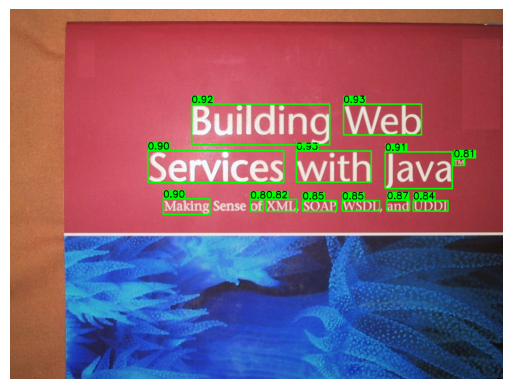

In [ ]:
from ultralytics import YOLO

model_path = '/content/drive/MyDrive/FPT/Semester 5/DPL302m/project/Project 3_ Traffic sign Detection/models/yolov8/detect/train/weights/best.pt'
img_path = '/content/SceneTrialTrain/apanar_06.08.2002/IMG_1317.JPG'
conf_thres= 0.75
model = YOLO(model_path)

# Run inference
results = model(img_path, verbose=False)
# print(results)
predictions = json.loads(results[0].tojson())
print(predictions)
visualized_img = visualize_bbox(img_path, predictions, conf_thres)

%matplotlib inline
plt.imshow(visualized_img)
plt.axis('off')
plt.show()

# **Text Recognition**

In [ ]:
!pip install -q timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.8 MB/s eta 0:00:00


In [ ]:
import os
import shutil
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd
import random
import cv2
import timm
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torchvision
from torch.nn import functional as F
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

## Dataset

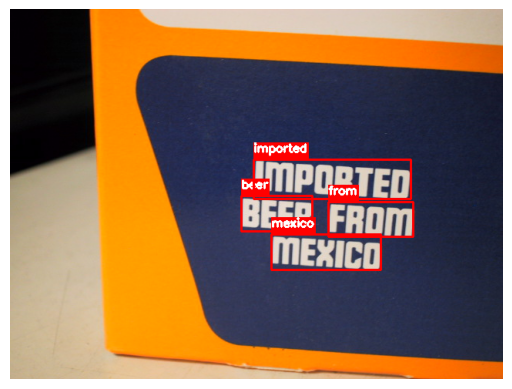

In [ ]:
def plot_image_with_bbs(img_path, bbs, labels):
    """
    Visualize bounding boxes with labels on an image.

    Parameters:
        img_path (str): Path to the image.
        bbs (list): List of bounding boxes.
        labels (list): List of labels.
    """
    # Read the image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Iterate through each bounding box
    for idx, bb in enumerate(bbs):
        # Draw bounding box on the image
        start_point = (int(bb[0]), int(bb[1]))
        end_point = (int(bb[0] + bb[2]), int(bb[1] + bb[3]))
        color = (255, 0, 0)
        thickness = 2
        img = cv2.rectangle(img, start_point, end_point, color, thickness)

        # Draw label near the bounding box
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.5
        font_color = (255, 255, 255)
        line_type = 2
        text_thickness = 2
        label = labels[idx]
        text_size, _ = cv2.getTextSize(label, font, font_scale, text_thickness)

        label_background_start = (int(bb[0]), int(bb[1] - text_size[1] - 10))
        label_background_end = (int(bb[0] + text_size[0]), int(bb[1]))
        img = cv2.rectangle(img, label_background_start, label_background_end, color, cv2.FILLED)

        cv2.putText(img, label, (int(bb[0]), int(bb[1] - 10)), font, font_scale, font_color, text_thickness, line_type)

    # Show the image
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Randomly select an image index to visualize
i = random.randint(0, len(image_paths))
plot_image_with_bbs(image_paths[i], bounding_boxes[i], image_labels[i])

In [ ]:
def split_bounding_boxes(img_paths, img_labels, bboxes, save_dir):
    """
    Build a directory containing data for Text Recognition.

    The function will create a save_dir, save cropped images from bbox coordinates.
    Labels will be saved separately to labels.txt.

    Parameters:
        img_paths (list): List of image paths.
        img_labels (list): List containing lists of labels for images.
        bboxes (list): List containing lists of bounding boxes for images.
        save_dir (str): Path to the data directory.
    """
    # Automatically create the data directory
    os.makedirs(save_dir, exist_ok=True)

    # Declare a counter and an empty list to store labels
    count = 0
    labels = []

    # Iterate over each pair (image path, label list, bbox list)
    for img_path, img_label, bbs in zip(img_paths, img_labels, bboxes):
        # Read image
        img = Image.open(img_path)

        # Iterate through each (label, bbox) pair
        for label, bb in zip(img_label, bbs):
            # Crop image according to bbox
            cropped_img = img.crop((bb[0], bb[1], bb[0] + bb[2], bb[1] + bb[3]))

            # Skip cases where 90% of the cropped image content is white or black
            if np.mean(cropped_img) < 35 or np.mean(cropped_img) > 220:
                continue

            # Skip cases where cropped image has width < 10 or height < 10
            if cropped_img.size[0] < 10 or cropped_img.size[1] < 10:
                continue

            # Skip cases where the label length < 3
            if len(label) < 3:
                continue

            # Create a filename for the cropped image and save it to save_dir
            filename = f"{count:06d}.jpg"
            cropped_img.save(os.path.join(save_dir, filename))

            new_img_path = os.path.join(save_dir, filename)

            # Add the new label format to the labels list
            # Format: img_path\tlabel
            label = new_img_path + '\t' + label

            labels.append(label)  # Append label to the list

            count += 1

    print(f"Created {count} images")

    # Write the labels list to labels.txt
    with open(os.path.join(save_dir, 'labels.txt'), 'w') as f:
        for label in labels:
            f.write(f"{label}\n")

In [ ]:
save_dir = 'datasets/ocr_dataset'
split_bounding_boxes(image_paths, image_labels, bounding_boxes, save_dir)

Created 928 images


In [ ]:
# Read data from created directory
root_dir = save_dir

img_paths = []
labels = []

with open(os.path.join(root_dir, 'labels.txt'), 'r') as f:
    for label in f:
        labels.append(label.strip().split('\t')[1])
        img_paths.append(label.strip().split('\t')[0])

print(f"Total images: {len(img_paths)}")

Total images: 928


In [ ]:
labels

In [ ]:
# Get all characters in the labels list
letters = "".join(labels)
letters = sorted(list(set(list(letters))))
letters

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [ ]:
# Convert list of characters to string
chars = "".join(letters)

# Add "blank" character to the vocabulary
blank_char = '-'
chars += blank_char
vocab_size = len(chars)

print(f'Vocab: {chars}')
print(f'Vocab size: {vocab_size}')

Vocab: 0123456789abcdefghijklmnopqrstuvwxyz-
Vocab size: 37


In [ ]:
# Create dictionaries to convert characters (classes) to numbers and vice versa
char_to_idx = {char: idx + 1 for idx, char in enumerate(sorted(chars))}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}

max_label_len = max([len(label) for label in labels])

In [ ]:
def encode(label, char_to_idx, max_label_len):
    """
    Encode label into a tensor

    Parameters:
        label (str): String label.
        char_to_idx (dict): Mapping table from classname -> ID.
        max_label_len (int): Maximum length for the label.

    Returns:
        padded_labels (tensor): Encoded and padded label tensor.
        lengths (tensor): Original length of the label before padding.
    """
    # Convert to tensor
    encoded_labels = torch.tensor(
        [char_to_idx[char] for char in label],
        dtype=torch.long
    )
    # Calculate label length
    label_len = len(encoded_labels)
    lengths = torch.tensor(
        label_len,
        dtype=torch.long
    )
    # Padding
    padded_labels = F.pad(
        encoded_labels,
        (0, max_label_len - label_len),
        value=0
    )

    return padded_labels, lengths

In [ ]:
def decode(encoded_sequences, idx_to_char, blank_char='-'):
    """
    Decode encoded labels into strings

    Parameters:
        encoded_sequences (list): List of label tensors.
        idx_to_char (dict): Mapping table from ID -> classname.
        blank_char (str): "Blank" character.

    Returns:
        decoded_sequences (list): List of decoded labels.
    """
    # Declare an empty list to store decoded results
    decoded_sequences = []

    # Iterate through each encoded label
    for seq in encoded_sequences:
        # Declare an empty list to store decoded characters
        decoded_label = []
        # Iterate through each token
        for idx, token in enumerate(seq):
            # Skip padding tokens (ID=0)
            if token != 0:
                # Get the character corresponding to the current token from idx_to_char
                char = idx_to_char[token.item()]
                # Skip the "blank" character
                if char != blank_char:
                    decoded_label.append(char)
        # Add the decoded string to the decoded_sequences list
        decoded_sequences.append(''.join(decoded_label))

    return decoded_sequences

In [ ]:
# Data preprocessing
data_transforms = {
    'train': transforms.Compose([transforms.Resize((100, 420)),
                                transforms.ColorJitter(brightness=0.5, # Randomly change the brightness, contrast, saturation and hue of an image
                                                        contrast=0.5,
                                                        saturation=0.5),
                                transforms.Grayscale(num_output_channels=1),
                                transforms.GaussianBlur(3), # k
                                transforms.RandomAffine(degrees=2, shear=2),
                                transforms.RandomPerspective(distortion_scale=0.4,
                                                            p=0.5,
                                                            interpolation=3),
                                transforms.RandomRotation(degrees=2),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
    ]),
    'val': transforms.Compose([transforms.Resize((100, 420)),
                                transforms.Grayscale(num_output_channels=1),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
    ]),
}

In [ ]:
# Train, val, test split
seed = 0
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    img_paths, labels,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=seed,
    shuffle=is_shuffle
)

In [ ]:
class STRDataset(Dataset):
    def __init__(
        self,
        X, y,
        char_to_idx,
        max_label_len,
        label_encoder=None,
        transform=None
    ):
        self.transform = transform
        self.img_paths = X
        self.labels = y
        self.char_to_idx = char_to_idx
        self.max_label_len = max_label_len
        self.label_encoder = label_encoder

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        if self.label_encoder:
            encoded_label, label_len = self.label_encoder(
                label,
                self.char_to_idx,
                self.max_label_len
            )
        return img, encoded_label, label_len

In [ ]:
train_dataset = STRDataset(
    X_train, y_train,
    char_to_idx=char_to_idx,
    max_label_len=max_label_len,
    label_encoder=encode,
    transform=data_transforms['train']
)
val_dataset = STRDataset(
    X_val, y_val,
    char_to_idx=char_to_idx,
    max_label_len=max_label_len,
    label_encoder=encode,
    transform=data_transforms['val']
)
test_dataset = STRDataset(
    X_test, y_test,
    char_to_idx=char_to_idx,
    max_label_len=max_label_len,
    label_encoder=encode,
    transform=data_transforms['val']
)

In [ ]:
test =  next(iter(train_dataset))

In [ ]:
test[1].shape

torch.Size([14])

In [ ]:
len(train_dataset), len(val_dataset), len(test_dataset)

(649, 186, 93)

In [ ]:
train_batch_size = 256
test_batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

['cask', 'home', 'new', 'light', 'wroxcom', 'intensely', 'tetley', 'ing', 'tymperleys', 'pull', 'group', 'clacton', 'town', 'man', 'leslie', 'volvo', 'the', 'publication', 'castle', 'canon', 'labels', 'pensions', 'reserved', 'are', 'park', 'website', 'food', 'licensed', 'festivals', 'wrox', 'alarm', 'use', 'information', 'fool', 'nokia', 'and', 'the', 'does', 'issues', 'west', 'modern', 'conditions', 'case', 'orange', 'campus', 'live', 'extra', 'box', 'iiyama', 'soap', 'castle', 'nigel', 'illustrated', 'strategy', 'centre', 'tesco', 'low', 'inspiron', 'stop', 'car', 'constantine', 'need', 'careers', 'semi', 'mobile', 'saloon', 'loxk', 'falling', 'lights', 'dollar', 'exit', 'monument', 'hire', 'colchester', 'manchester', 'moto', 'ford', 'high', 'inhabited', 'united', 'greenstead', 'and', 'the', 'construction', 'mexican', 'homogenic', 'systems', 'wroxcom', 'and', 'overseas', 'pronto', 'management', 'section', 'mexico', 'sixth', 'asda', 'support', 'will', 'call', 'for', 'adapter', 'when',

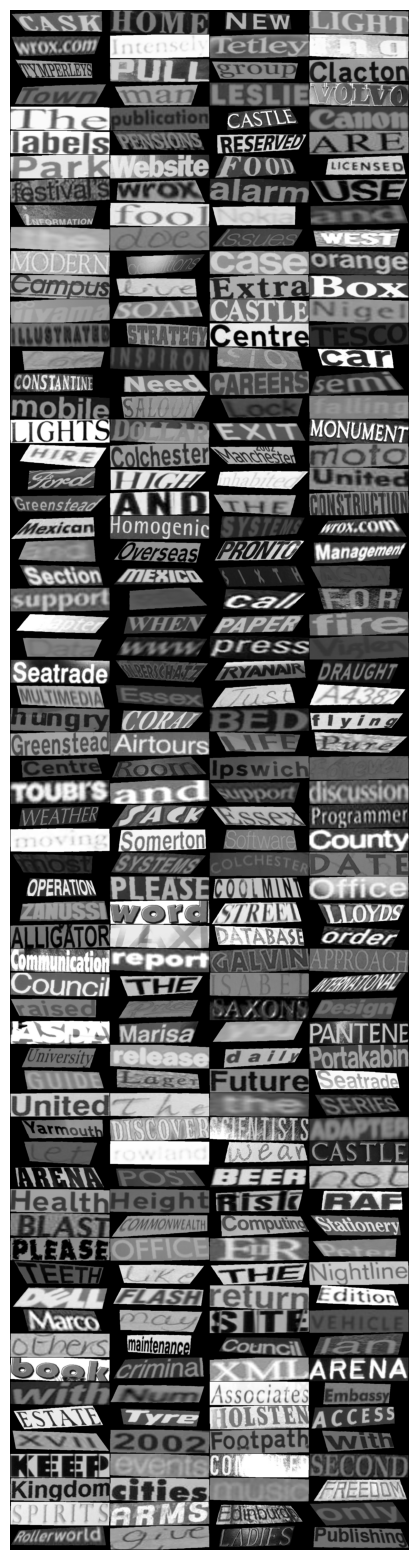

In [ ]:
train_features, train_labels, train_lengths = next(iter(train_loader))

# use torchvision to display a grid of images
def show_batch(imgs, labels):
    labels = decode(labels, idx_to_char)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True)
    plt.figure(figsize=(10, 20))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.axis('off')
    print(labels)
    plt.show()

show_batch(train_features, train_labels)

## Model

https://arxiv.org/pdf/1507.05717.pdf


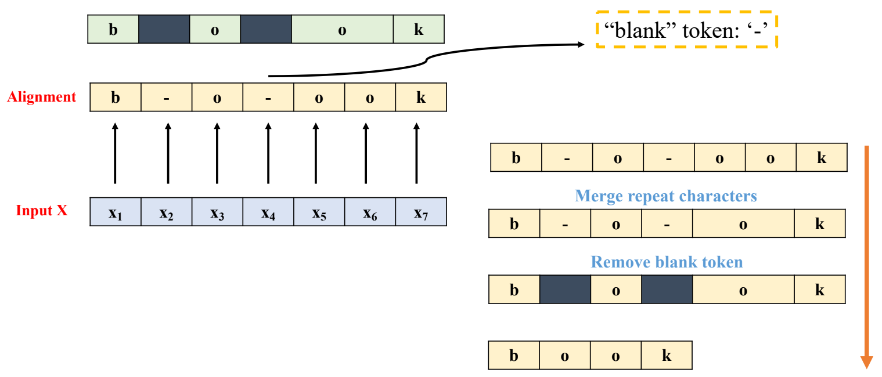

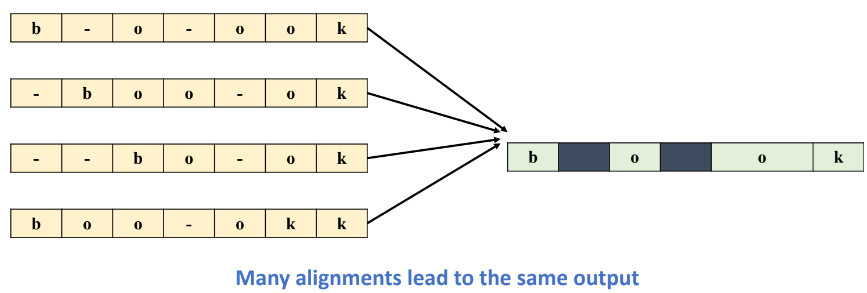

https://tiensu.github.io/blog/65_ocr_crnn_model_ctc_loss_function/

In [ ]:
class CRNN(nn.Module): # paper goc
    def __init__(
        self,
        in_channels,
        vocab_size,
        hidden_size,
        n_layers,
        dropout=0.2
    ):
        super(CRNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2, 2), (2, 1), (0, 1))
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2, 2), (2, 1), (0, 1))
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=2, stride=1, padding=0),
            nn.ReLU(inplace=True),
        )

        self.mapSeq = nn.Linear(512, 64)

        self.lstm = nn.LSTM(
            64, hidden_size,
            num_layers=n_layers,
            bidirectional=True,
            dropout=dropout if n_layers > 1 else 0
        )
        #self.dropout = nn.Dropout(dropout)
        self.out = nn.Sequential(
            nn.Linear(hidden_size * 2, vocab_size),
            nn.LogSoftmax(dim=2)
        )


    def forward(self, x):
        # (16, 1, 32, 100)
        x = self.conv1(x) # [16, 64, 16, 50]
        x = self.conv2(x) # [16, 128, 8, 25]
        x = self.conv3(x) # [16, 256, 4, 26]
        x = self.conv4(x) # [16, 512, 2, 27]
        x = self.conv5(x) # [16, 512, 1, 26]

        batch, channel, height, width = x.size()
        x = x.view(batch, channel * height, width) # [16, 512, 26]
        x = x.permute(0, 2, 1) # [16, 26, 512]
        x = self.mapSeq(x) # # [16, 26, 64]
        x, _ = self.lstm(x) # [16, 26, 512]
        #x = self.dropout(x)
        x = self.out(x) # [16, 26, 37]
        x = x.permute(1, 0, 2) # [26, 16, 37] # (seq_len, bs, n_classes)
        return x

In [ ]:
hidden_size = 256
n_layers = 2
dropout_prob = 0.3
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = CRNN(
    in_channels=1,
    vocab_size=vocab_size,
    hidden_size=hidden_size,
    n_layers=n_layers,
    dropout=dropout_prob,
).to(device)

In [ ]:
model.eval()

dummy_tensor = torch.rand((16, 1, 32, 100)).to(device)

with torch.no_grad():
    output = model(dummy_tensor)

print('Output shape:', output.shape)

torch.Size([26, 16, 64])
torch.Size([26, 16, 512])
torch.Size([26, 16, 37])
Output shape: torch.Size([26, 16, 37])


In [ ]:
backbone = timm.create_model(
            'resnet101',
            in_chans=1,
            pretrained=True)
backbone

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/179M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

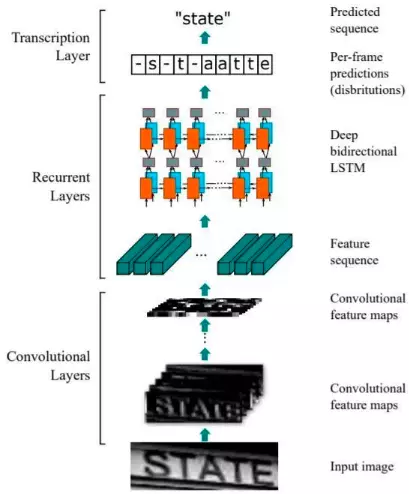

In [ ]:
class CRNN(nn.Module):
    def __init__(
        self,
        vocab_size,
        hidden_size,
        n_layers,
        dropout=0.2,
        unfreeze_layers=3
    ):
        super(CRNN, self).__init__()

        # Initialize pretrained resnet101
        backbone = timm.create_model(
            'resnet101',
            in_chans=1,
            pretrained=True
        )

        # Remove the original classifier layer of the pretrained model
        modules = list(backbone.children())[:-2] # [bs, 2048, 4, 14]

        # Add AdaptiveAvgPool2d
        modules.append(nn.AdaptiveAvgPool2d((1, None))) # [bs, 2048, 1, 14]
        self.backbone = nn.Sequential(*modules)

        # Unfreeze a number of the last layers of the pretrained model
        for parameter in self.backbone[-unfreeze_layers:].parameters():
            parameter.requires_grad = True

        # Layer to map from CNN feature maps to LSTM
        self.mapSeq = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        self.lstm = nn.LSTM(
            1024, hidden_size,
            n_layers, bidirectional=True, batch_first=True,
            dropout=dropout if n_layers > 1 else 0
        )
        self.layer_norm = nn.LayerNorm(hidden_size * 2)
        self.out = nn.Sequential(
            nn.Linear(hidden_size * 2, vocab_size),
            nn.LogSoftmax(dim=2)
        )

        def forward(self, x):
            # [64, 1, 100, 420]

            x = self.backbone(x) # [64, 2048, 1, 14]
            x = x.permute(0, 3, 1, 2) # [64, 14, 2048, 1]
            x = x.view(x.size(0), x.size(1), -1)  # [64, 14, 2048]
            x = self.mapSeq(x) # [64, 14, 1024]
            x, _ = self.lstm(x) # [64, 14, 512]
            x = self.layer_norm(x)
            x = self.out(x) # [64, 14, 37]

            x = x.permute(1, 0, 2) # Based on CTC # (seq_len, bs, n_classes)
            return x

In [ ]:
hidden_size = 256
n_layers = 2
dropout_prob = 0.3
unfreeze_layers=3
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = CRNN(
    vocab_size=vocab_size,
    hidden_size=hidden_size,
    n_layers=n_layers,
    dropout=dropout_prob,
    unfreeze_layers=unfreeze_layers
).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/179M [00:00<?, ?B/s]

In [ ]:
model.eval()

dummy_tensor = torch.rand((64, 1, 100, 420)).to(device)

with torch.no_grad():
    output = model(dummy_tensor)

print('Output shape:', output.shape)

Output shape: torch.Size([14, 64, 37])


## Training

In [ ]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for inputs, labels, labels_len in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels_len = labels_len.to(device)

            outputs = model(inputs)
            # Calculate len of model outputs
            logits_lens = torch.full(
                size=(outputs.size(1),),
                fill_value=outputs.size(0),
                dtype=torch.long
            ).to(device)

            loss = criterion(
                outputs, labels, logits_lens, labels_len
            )
            losses.append(loss.item())

    loss = sum(losses) / len(losses)

    return loss

In [ ]:
def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, (inputs, labels, labels_len) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels_len = labels_len.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            # Compute length of model outputs
            logits_lens = torch.full(
                size=(outputs.size(1),),
                fill_value=outputs.size(0),
                dtype=torch.long
            ).to(device)

            loss = criterion(outputs, labels, logits_lens, labels_len)
            loss.backward()
            # Perform gradient clipping
            torch.nn.utils.clip_grad_norm_(
                model.parameters(),
                5
            )
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss = evaluate(
            model, val_loader,
            criterion, device
        )
        val_losses.append(val_loss)

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}')

        scheduler.step()

    return train_losses, val_losses

In [ ]:
epochs = 150
lr = 0.0001
weight_decay=1e-5
scheduler_step_size = epochs * 0.5

criterion = nn.CTCLoss(
    blank=char_to_idx[blank_char],
    zero_infinity=True
)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr,
    weight_decay=weight_decay
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=scheduler_step_size,
    gamma=0.1
)

In [ ]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
)

EPOCH 1:	Train loss: 3.8231	Val loss: 3.5001
EPOCH 2:	Train loss: 3.3893	Val loss: 3.5222
EPOCH 3:	Train loss: 3.1716	Val loss: 3.0937
EPOCH 4:	Train loss: 2.8703	Val loss: 2.8268
EPOCH 5:	Train loss: 2.4585	Val loss: 2.1771
EPOCH 6:	Train loss: 1.8996	Val loss: 1.6618
EPOCH 7:	Train loss: 1.3053	Val loss: 1.2364
EPOCH 8:	Train loss: 0.9914	Val loss: 1.0191
EPOCH 9:	Train loss: 0.7832	Val loss: 0.8944
EPOCH 10:	Train loss: 0.6938	Val loss: 0.8266
EPOCH 11:	Train loss: 0.5906	Val loss: 0.7473
EPOCH 12:	Train loss: 0.4587	Val loss: 0.6703
EPOCH 13:	Train loss: 0.4329	Val loss: 0.6936
EPOCH 14:	Train loss: 0.3899	Val loss: 0.7703
EPOCH 15:	Train loss: 0.3851	Val loss: 0.7673
EPOCH 16:	Train loss: 0.3152	Val loss: 0.7900
EPOCH 17:	Train loss: 0.3372	Val loss: 0.7893
EPOCH 18:	Train loss: 0.2930	Val loss: 0.7237
EPOCH 19:	Train loss: 0.2960	Val loss: 0.7214
EPOCH 20:	Train loss: 0.2686	Val loss: 0.7805
EPOCH 21:	Train loss: 0.2977	Val loss: 0.6980
EPOCH 22:	Train loss: 0.2281	Val loss: 0.69

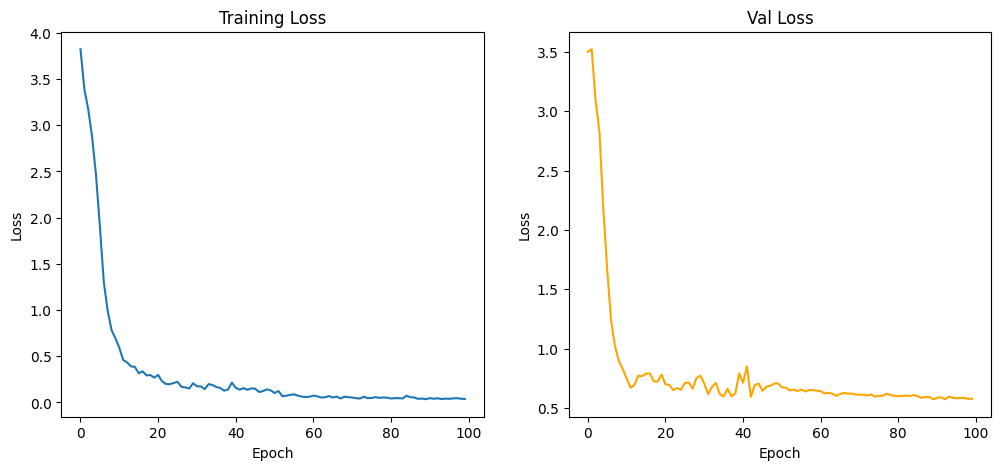

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(train_losses)
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].plot(val_losses, color='orange')
ax[1].set_title('Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
plt.show()

In [ ]:
val_loss = evaluate(
    model,
    val_loader,
    criterion,
    device
)
test_loss = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print('Evaluation on val/test dataset')
print('Val loss: ', val_loss)
print('Test loss: ', test_loss)

Evaluation on val/test dataset
Val loss:  0.5768467847568294
Test loss:  0.552143254588979


## Inference

In [ ]:
def predict(model, img):
    model.eval()
    with torch.no_grad():
        outputs = model(img)
        print(outputs)

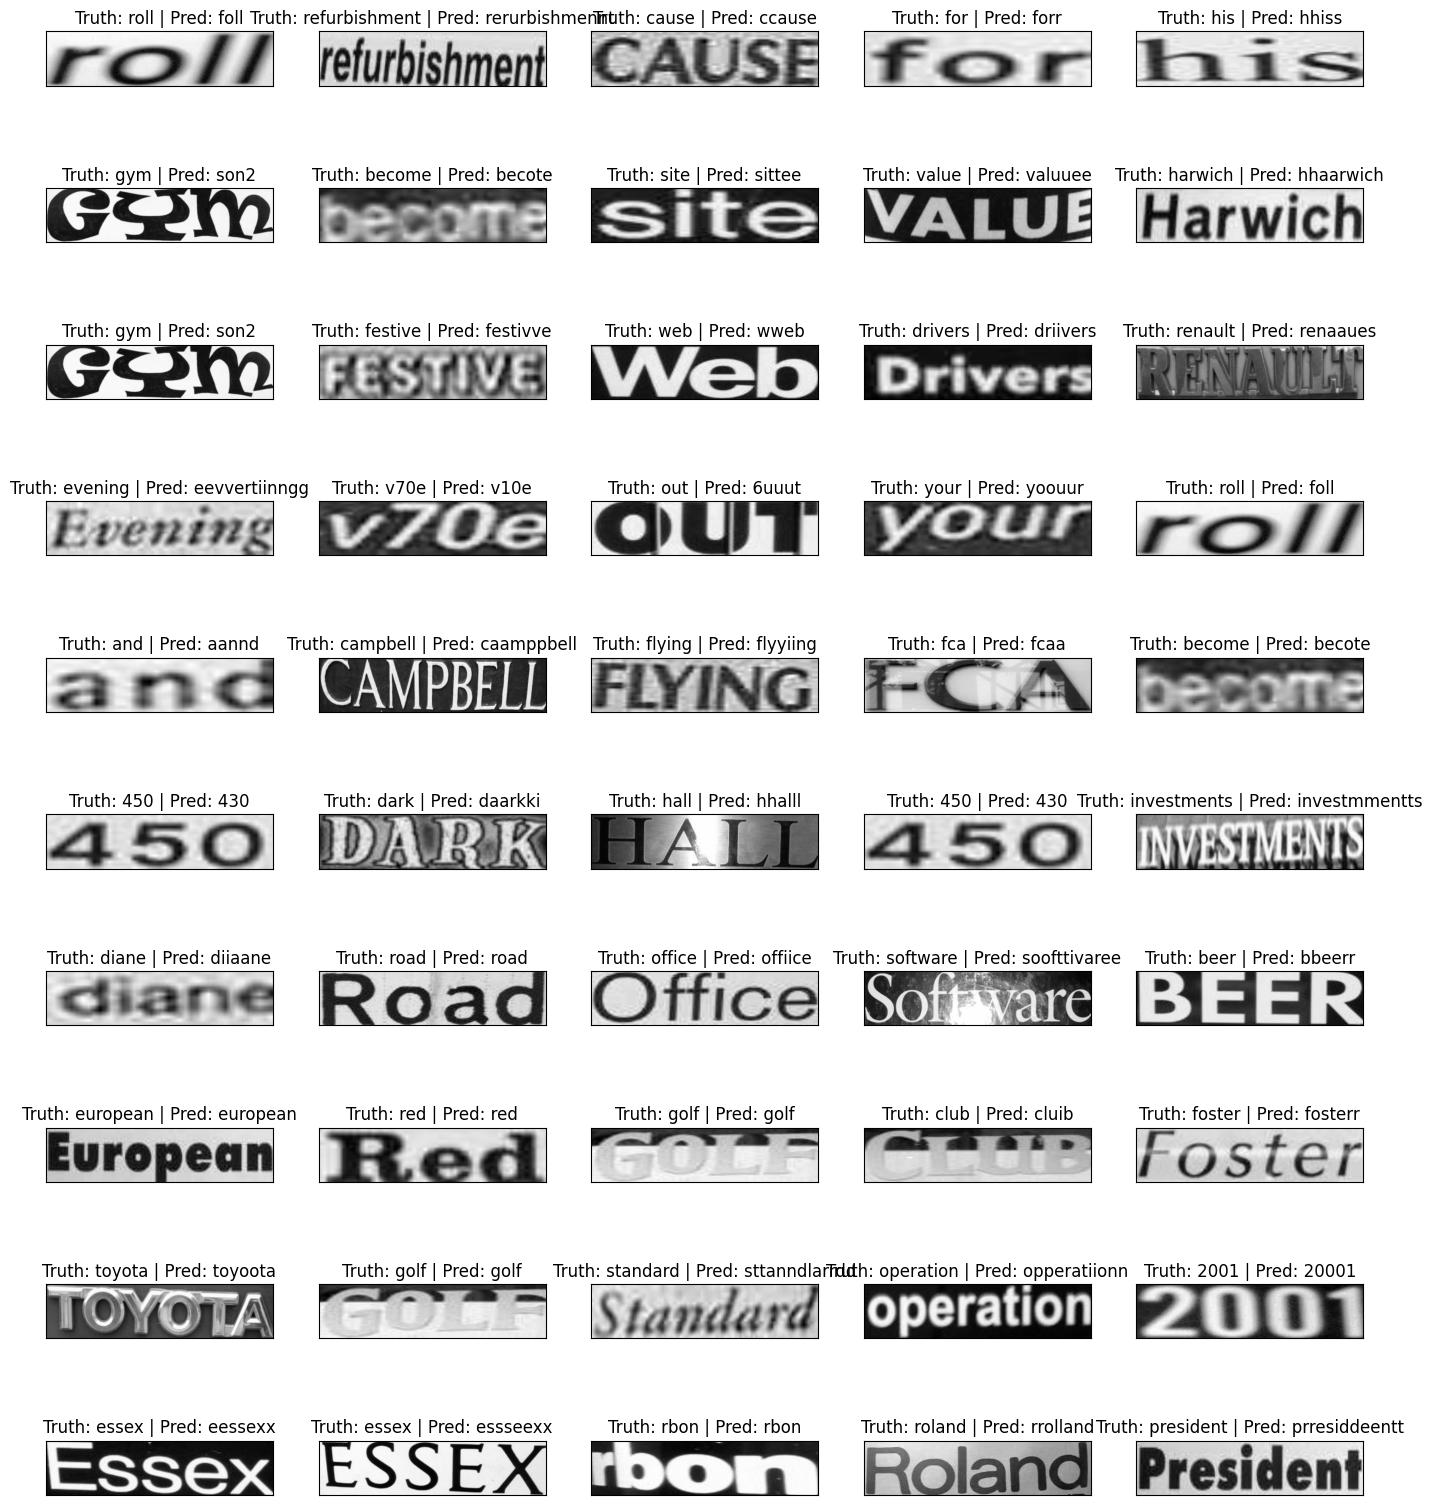

In [ ]:
# view samples
sample_result = []

for i in range(50):
    idx = np.random.randint(len(val_dataset))
    img, label, label_len = val_dataset[idx]
    img = img.to(device)
    label = label.to(device)
    label = decode([label], idx_to_char)[0]
    logits = model(img.unsqueeze(0))

    pred_text = decode(logits.permute(1, 0, 2).argmax(2), idx_to_char)[0]

    sample_result.append((img, label, pred_text))

fig = plt.figure(figsize=(17, 20))
for i in range(50):
    ax = fig.add_subplot(10, 5, i+1, xticks=[], yticks=[])

    img, label, pred_text = sample_result[i]
    img = img.cpu()
    title = f'Truth: {label} | Pred: {pred_text}'

    ax.imshow(img.permute(1, 2, 0), cmap='gray')
    ax.set_title(title)

plt.show()

In [ ]:
save_model_path = '/content/drive/MyDrive/FPT/Semester 5/DPL302m/project/Project 3_ Traffic sign Detection/models/ocr_crnn_resnet_best.pt'
torch.save(
    model.state_dict(),
    save_model_path
)

# **Full pipeline**

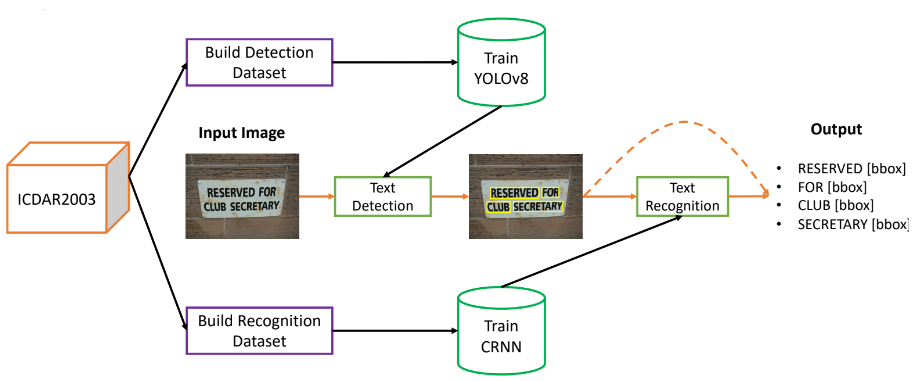

In [ ]:
!pip install timm -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.0 MB/s eta 0:00:00


In [ ]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.1.18 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.3/78.2 GB disk)


In [ ]:
import os
import numpy as np
import timm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision import models
from torchvision import transforms
from PIL import Image

## Load model

In [ ]:
from ultralytics import YOLO

text_det_model_path = '/content/drive/MyDrive/FPT/Semester 5/DPL302m/project/Project 3_ Scene text recognition/models/yolov8/detect/train/weights/best.pt'
yolo = YOLO(text_det_model_path)

In [ ]:
chars = '0123456789abcdefghijklmnopqrstuvwxyz-'
vocab_size = len(chars)
char_to_idx = {char: idx + 1 for idx, char in enumerate(sorted(chars))}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}

In [ ]:
hidden_size = 256
n_layers = 2
dropout_prob = 0.3
unfreeze_layers=3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_path = '/content/drive/MyDrive/FPT/Semester 5/DPL302m/project/Project 3_ Scene text recognition/models/ocr_crnn_resnet_best.pt'

crnn_model = CRNN(
    vocab_size=vocab_size,
    hidden_size=hidden_size,
    n_layers=n_layers,
    dropout=dropout_prob,
    unfreeze_layers=unfreeze_layers
).to(device)
crnn_model.load_state_dict(torch.load(model_path))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/179M [00:00<?, ?B/s]

<All keys matched successfully>

## Inference

In [ ]:
def text_detection(img_path, text_det_model):
    """
    Detect text regions (bounding boxes) in an image.

    Parameters:
        img_path (str): Path to the image file.
        text_det_model (YOLO): YOLO text detection model.

    Returns:
        tuple: Contains detected components (bboxes, classes, names, confs)
    """
    # Perform detection using YOLO
    text_det_results = text_det_model(img_path, verbose=False)[0]

    # Extract bounding box information (format xyxy)
    bboxes = text_det_results.boxes.xyxy.tolist()

    # Extract class names and confidence scores
    classes = text_det_results.boxes.cls.tolist()

    names = text_det_results.names
    confs = text_det_results.boxes.conf.tolist()

    return bboxes, classes, names, confs


In [ ]:
def text_recognition(img, data_transforms, text_reg_model, idx_to_char, device):
    """
    Recognize text in an image.

    Parameters:
        img (PIL.Image): Image object.
        data_transforms (transforms.Compose): Image preprocessing function.
        text_reg_model (CRNN): CRNN text recognition model.
        idx_to_char (dict): Mapping table from ID -> classname.
        device (str): 'cpu' or 'gpu'.

    Returns:
        text (str): Recognized text.
    """
    transformed_image = data_transforms(img)
    transformed_image = transformed_image.unsqueeze(0).to(device)
    text_reg_model.eval()
    with torch.no_grad():
        logits = text_reg_model(transformed_image).detach().cpu()
    text = decode(logits.permute(1, 0, 2).argmax(2), idx_to_char)

    return text

In [ ]:
def visualize_detections(img, detections):
    """
    Visualize the results of Scene Text Recognition (STR).

    Parameters:
        img (PIL.Image): The image object.
        detections (list): A list of STR results found in the image.
    """
    # Setup the plot figure
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.axis('off')

    # Iterate through each detection (bbox, classname, conf, text)
    for bbox, detected_class, confidence, transcribed_text in detections:
        x1, y1, x2, y2 = bbox
        # Draw the bounding box (bbox) and the recognized text
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='red', linewidth=2))
        plt.text(
            x1, y1 - 10, f"{detected_class} ({confidence:.2f}): {transcribed_text}",
            fontsize=9, bbox=dict(facecolor='red', alpha=0.5)
        )

    plt.show()

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((100, 420)),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
        transforms.Grayscale(num_output_channels=1),
        transforms.GaussianBlur(3),
        transforms.RandomAffine(degrees=1, shear=1),
        transforms.RandomPerspective(distortion_scale=0.2, p=0.3, interpolation=3),
        transforms.RandomRotation(degrees=2),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]),
    'val': transforms.Compose([
        transforms.Resize((100, 420)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]),
}

def predict(img_path, data_transforms, text_det_model, text_reg_model, idx_to_char, device, visualize=True):
    """
    Perform Scene Text Recognition on any given image.

    Parameters:
        img_path (str): Path to the image file.
        data_transforms (transforms.Compose): Image preprocessing function.
        text_det_model (YOLO): YOLO text detection model.
        text_reg_model (CRNN): CRNN text recognition model.
        idx_to_char (dict): Mapping from idx->classname.
        device (str): 'cpu' or 'gpu'.
        visualize (bool): Enable visualization of STR results.

    Returns:
        predictions (list): List of STR results on the image.
    """
    # Perform text detection
    bboxes, classes, names, confs = text_detection(img_path, text_det_model)

    # Load image
    img = Image.open(img_path)

    # Declare an empty list to store STR results
    predictions = []

    # Iterate through each detection result
    for bbox, cls, conf in zip(bboxes, classes, confs):
        x1, y1, x2, y2 = bbox  # Get bbox coordinates
        confidence = conf  # Get confidence score
        detected_class = cls  # Get class ID
        name = names[int(cls)]  # Get class name by ID

        # Crop image according to bbox
        cropped_image = img.crop((x1, y1, x2, y2))

        # Perform text recognition on the cropped image
        transcribed_text = text_recognition(
            cropped_image,
            data_transforms,
            text_reg_model,
            idx_to_char,
            device
        )

        # Add STR result to the predictions list
        predictions.append((bbox, name, confidence, transcribed_text))

    # Visualize STR results if enabled
    if visualize:
        visualize_detections(img, predictions)

    return predictions

In [ ]:
# Perform the predict() function call on images from the IC03 dataset
img_dir = '/content/datasets/yolo_data/test/images'
inf_transforms = data_transforms['val']

for img_filename in os.listdir(img_dir):
    img_path = os.path.join(img_dir, img_filename)
    predictions = predict(
        img_path,
        data_transforms=inf_transforms,
        text_det_model=yolo,
        text_reg_model=crnn_model,
        idx_to_char=idx_to_char,
        device=device,
        visualize=True
    )

Output hidden; open in https://colab.research.google.com to view.